In [16]:
# imports
%matplotlib inline
# %pylab osx
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
plt.style.use('ggplot')

## Neuro network to paint 

- ### this is just a demo, for better implementation look at this 

Instead of using a network to go from some x position to the value of a sine wave, what we're going to do instead teach a network to go from the location on an image frame to a particular color. So given any position in an image, the network will need to learn what color to paint.

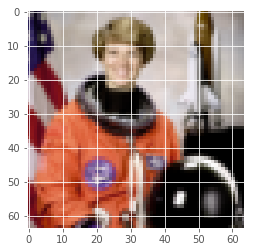

In [17]:
from skimage.data import astronaut
from scipy.misc import imresize
img = imresize(astronaut(), (64, 64))
plt.imshow(img)

In [18]:
img.shape

(64, 64, 3)

- 1. set up inputs and outputs 
- inputs are the positions and outputs are the coresponding colors

In [19]:
# We'll first collect all the positions in the image in our list, xs
xs = []

# And the corresponding colors for each of these positions
ys = []

# Now loop over the image
for row_i in range(img.shape[0]):
    for col_i in range(img.shape[1]):
        # And store the inputs
        xs.append([row_i, col_i])           ##
        # And outputs that the network needs to learn to predict
        ys.append(img[row_i, col_i])

# we'll convert our lists to arrays
xs = np.array(xs)
ys = np.array(ys)

# Normalizing the input by the mean and standard deviation
xs = (xs - np.mean(xs)) / np.std(xs)

# and print the shapes
xs.shape, ys.shape


((4096, 2), (4096, 3))

What we're going to do is use regression to predict the value of a pixel given its (row, col) position. So the input to our network is X = (row, col) value. And the output of the network is Y = (r, g, b).
We can get our original image back by reshaping the colors back into the original image shape:

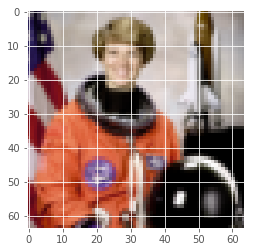

In [20]:
# let's take a look at y value
# should be the same as the original picture
plt.imshow(ys.reshape(img.shape)) 

### Build the network

#### Our input has 2 features, x position and y position. our output has 3 features rgb values

In [21]:
tf.reset_default_graph()

## input and output 
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')
Y = tf.placeholder(tf.float32, shape=[None, 3], name='Y')

## define linear fully connected layer 
def linear(X, n_input, n_output, activation=None, scope=None):
    with tf.variable_scope(scope or "linear"):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.1))
        b = tf.get_variable(
            name='b',
            shape=[n_output],
            initializer=tf.constant_initializer())
        h = tf.matmul(X, W) + b
        if activation is not None:
            h = activation(h)
        return h

## 6 hidden fully connected layer
n_neurons = [2, 64, 64, 64, 64, 64, 64, 3]

current_input = X
for layer_i in range(1, len(n_neurons)):
    current_input = linear(
        X=current_input,
        n_input=n_neurons[layer_i - 1],
        n_output=n_neurons[layer_i],
        activation=tf.nn.relu if (layer_i+1) < len(n_neurons) else None,  # for output layer, we do not apply activation function
        scope='layer_' + str(layer_i))
Y_pred = current_input


### Training

In [22]:
def distance(p1, p2):
    return tf.abs(p1 - p2)

cost = tf.reduce_mean(tf.reduce_sum(distance(Y_pred, Y), 1))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

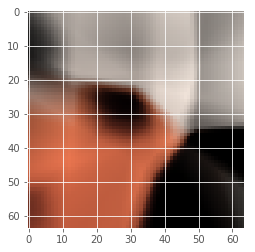

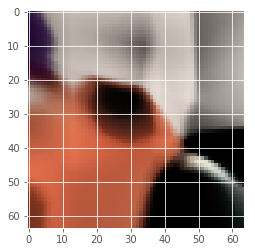

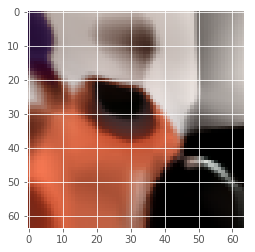

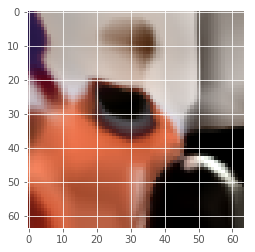

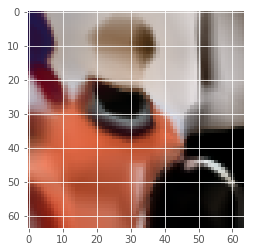

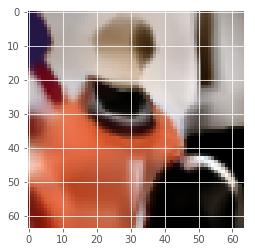

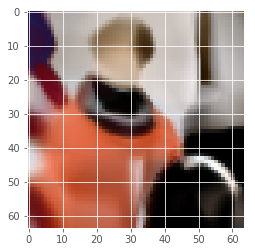

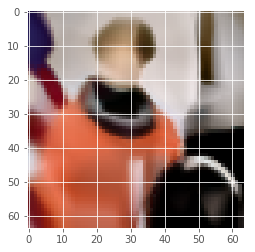

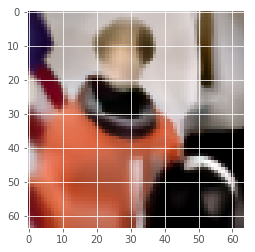

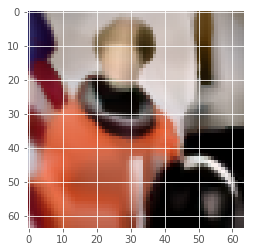

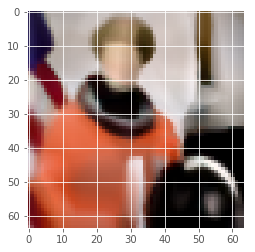

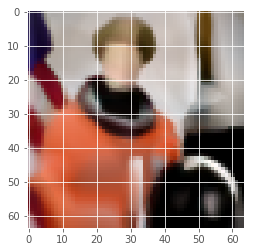

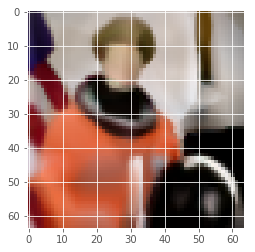

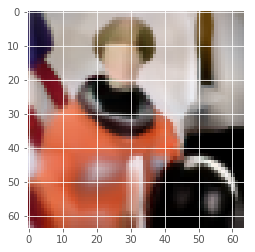

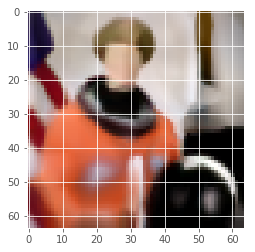

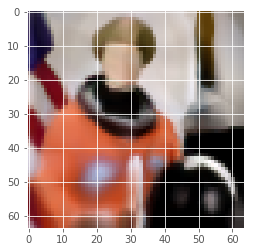

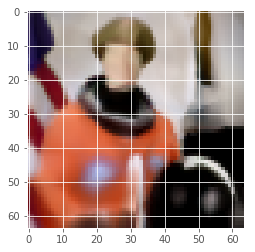

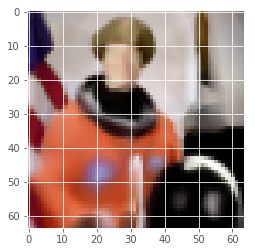

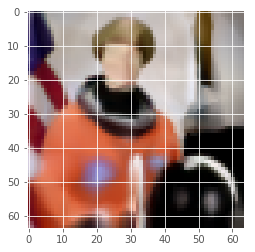

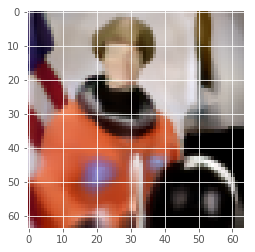

In [23]:
n_iterations = 1000
batch_size = 50 

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    prev_training_cost = 0.0
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        n_batches = len(idxs) // batch_size
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            sess.run(optimizer, feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})

        training_cost = sess.run(cost, feed_dict={X: xs, Y: ys})
        #print(it_i, training_cost)

        if (it_i + 1) % 50 == 0:
            ys_pred = Y_pred.eval(feed_dict={X: xs}, session=sess)
            fig, ax = plt.subplots(1, 1)
            img = np.clip(ys_pred.reshape(img.shape), 0, 255).astype(np.uint8)
            plt.imshow(img)
            plt.show()